# MONTE CARLO DROPOUT X JCGM
Incerteza Epistêmica em Redes Neurais - Gerson Eduardo de Mello 

Esta é uma aplicação do método de incerteza em redes neurais JCGM e MC dropout proposto por Yarin Gal. O Dataset escolhido foi O 
Airfoil Self-Noise Data Set (http://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise ) retirado do UCL Machine Learn Repository. A variável predita escolhida foi a "Pressure" e todas as demais foram consideradas como variáveis preditoras. 

Este artigo aborda a aplicação da incerteza em aprendizagem profunda denrto do domínio das
ciências físicas. O estudo destaca a importância de avaliar e quantificar as incertezas associadas
a essas previsões, considerando tanto as incertezas epistêmicas relacionadas ao conhecimento do
modelo quanto as incertezas aleatórias provenientes dos dados utilizados. A proposta consiste em
aplicar uma metodologia já consolidada nas ciências físicas, referenciada no JCGM 100:2008, com
adaptações específicas para estimar a incerteza aleatória que é proveniente dos dados, epistêmica
oriunda do modelo e preditiva (relacionadas à previsão) de uma rede neural treinada. O objetivo
principal é desenvolver um algoritmo de fácil aplicação, sem custo computacional que trabalhe
em paralelo com o algoritmo de predição da própria rede neural, permitindo associar a cada valor
predito um intervalo de abrangência de 95% de probabilidade em torno desse valor. Para validar
a eficácia dessa abordagem, realizaremos uma comparação entre a metodologia JCGM 100:2008
e uma abordagem Bayesiana, com foco no método Monte Carlo Dropout, para estimar a incerteza
epistêmica. Utilizaremos um conjunto de dados disponibilizado pelo UC Irvine Machine Learning
Repository como benchmark para avaliar e comparar os resultados obtidos por essas abordagens.A
análise das incertezas provenientes de uma mesma rede neural demonstra que o método JCGM
apresenta-se promissor às condições reais no domínio das ciências físicas. A disponibilidade do código
em  permite a reprodução dos experimentos e facilita o acesso à metodologia proposta.Este estudo contribui para aprimorar o
uso da aprendizagem profunda nas ciências físicas, fornecendo uma compreensão mais completa das
incertezas associadas às previsões, o que é essencial para a confiabilidade e aplicabilidade desses
modelos em diversas áreas de pesquisa

# Manipulando os dados 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-learn



%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [2]:
# importando os dados  

In [3]:
df=pd.read_csv('airfoil.csv')

In [4]:
df

,Frequency,Angle,Length,Velocity,Suction Side,Pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


Após a avaliação da distribuição dos dados para cada uma das variáveis, pode-se aplicar a normalização que é a mais apropriada do que a padronização uma vez que oas distribuições não seguem uma normalidade

In [5]:
from sklearn.preprocessing import MinMaxScaler 

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
df_n = scaler.fit_transform(df)
print(df_n)

[[0.03030303 0.         1.         1.         0.03900472 0.60682852]
 [0.04040404 0.         1.         1.         0.03900472 0.58023772]
 [0.0530303  0.         1.         1.         0.03900472 0.60018082]
 ...
 [0.19191919 0.7027027  0.27272727 0.19949495 0.90411066 0.08572872]
 [0.24242424 0.7027027  0.27272727 0.19949495 0.90411066 0.07562422]
 [0.30808081 0.7027027  0.27272727 0.19949495 0.90411066 0.02191081]]


In [7]:
df_n=pd.DataFrame(df_n)

In [8]:
y=df_n[5]

In [9]:
X=df_n[df_n.columns[0:5]]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=True, random_state=32)

# Construção e treino da rede neural 

In [11]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

In [12]:
#construimos a rede neural

In [13]:
n_input = 5  # numero de entradas das rede neural 
num_out = 1
p_dropout = 0.5 # probabilidade dropout 

lbd = 1e-4  # L2- força de regularização 

model = Sequential()
model.add(Dropout(.05, input_shape=(n_input,)))
model.add(Dense(100, activation='relu', input_shape=(n_input,), kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(num_out, activation=None))
model.summary()

opt = Adam(lr=1e-3) 

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mean_absolute_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 100)               600       
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,801
Trainable params: 10,801
Non-traina

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Treino RNN

In [14]:
epochs = 10000
model.fit(X_train, y_train,
            batch_size=X_train.shape[0] // 1,
            epochs=epochs,
            verbose=0)

# Avaliamos a performance do modelo

In [15]:
from sklearn import metrics

y_hat_train = model.predict(X_train)# passamos  o conjunto de treino pela rede e obtemos as predições 


46/46 [==============================] - 0s 634us/step


In [16]:
y_hat_test = model.predict(X_test)# passamos  o conjunto de teste pela rede e obtemos as predições


1/1 [==============================] - 0s 47ms/step


In [17]:
# métricas do treino

In [18]:
MAE_T=metrics.mean_absolute_error(y_train, y_hat_train)
R2_T=metrics.r2_score(y_train, y_hat_train);
RMSE_T=metrics.mean_squared_error(y_train, y_hat_train)

In [19]:
MAE_T,R2_T,RMSE_T

(0.0519067342693366, 0.8587163281819212, 0.0047903227297249554)

In [20]:
# métricas do teste

In [21]:
MAE_t=metrics.mean_absolute_error(y_test, y_hat_test)
R2_t=metrics.r2_score(y_test, y_hat_test);
RMSE_t=metrics.mean_squared_error(y_test, y_hat_test)

In [22]:
MAE_t,R2_t,RMSE_t

(0.043410891921356824, 0.8516918762877355, 0.0029909240756244805)

# Determinação do erro aleatório e erro sistemático em todo o dataset

In [23]:
previsão=model.predict(X[:1503])# passando todos os dados pela rede ( sem distinção de treino e teste)

47/47 [==============================] - 0s 678us/step


In [24]:
previsão=pd.DataFrame(previsão)

In [25]:
df.resume4=pd.concat([X,y,previsão],axis=1) #criando data frame com os valores do vetor x mais a coluna da previsão 

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_16172\1795452580.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.resume4=pd.concat([X,y,previsão],axis=1) #criando data frame com os valores do vetor x mais a coluna da previsão


In [26]:
df.resume4.columns=['x1','x2','x3','x4','x5','y','predict']

In [27]:

erro=df.resume4['predict']-df.resume4['y']#determinando o erro emtre o real e a predição 

es=erro.loc[:,].mean()

ea=erro.loc[:,].std()


In [28]:
erro=pd.DataFrame(erro)

In [29]:
ea

0.06894005786682286

In [30]:
es

-0.001907867641346774

In [31]:
erro.describe()# confirmando os resultados

,0
count,1503.000000
mean,-0.001908
std,0.068940
min,-0.367807
25%,-0.042233
50%,-0.001926
75%,0.038223
max,0.250677


C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


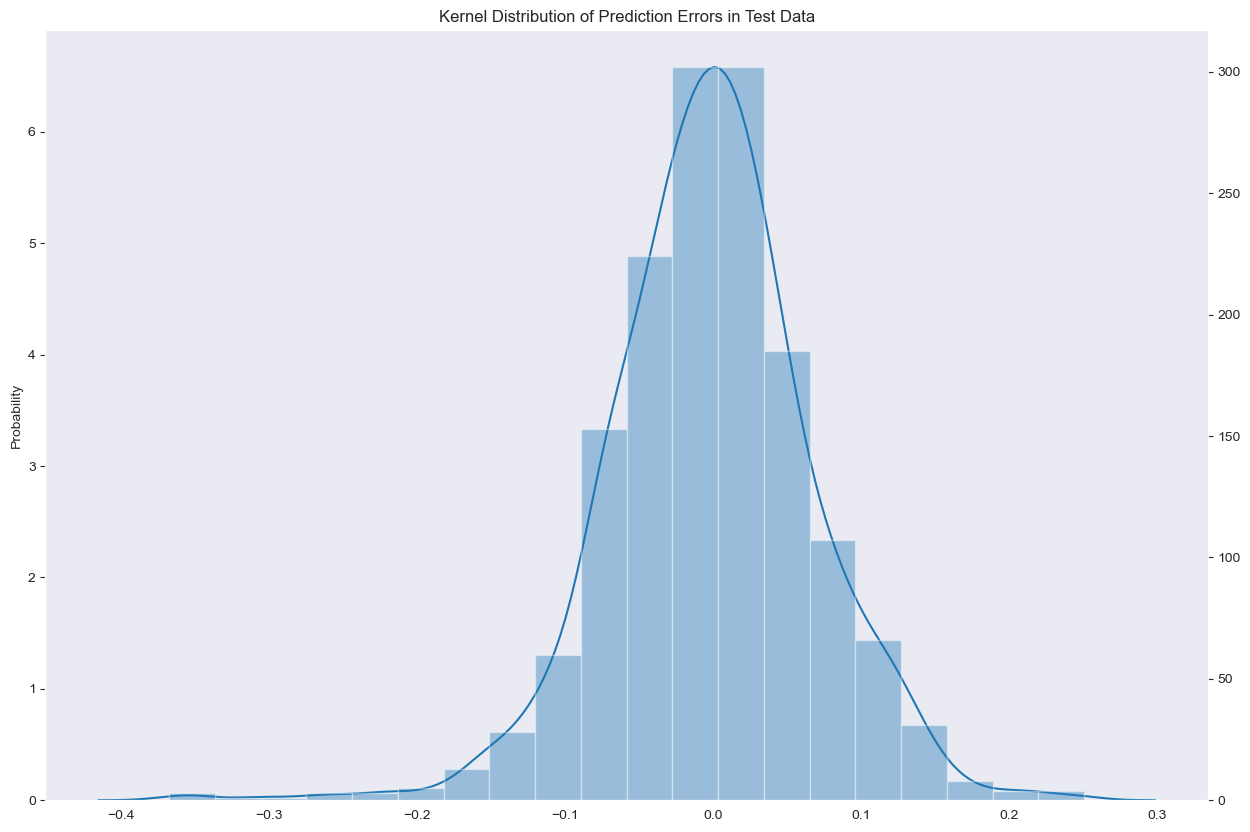

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

bins = 20

# Criando o ambiente do gráfico 
sns.set_style("dark")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Insere curva KDE (Kernel Density Estimation)
g1 = sns.distplot(erro, ax=ax, 
                  kde=True, hist=False) 

# Insere histograma
ax_copy = ax.twinx()
g2 = sns.distplot(erro, ax=ax_copy, kde=False, hist=True, 
             bins=bins, norm_hist=False)

# Ajusta rótulos
g1.set_ylabel("Probability")
g2.set_title("Kernel Distribution of Prediction Errors in Test Data")

plt.show()


In [33]:
# elaboração do gráfico ordenando os dados em ordem e plotando os valores reais e predito no conjunto de teste 

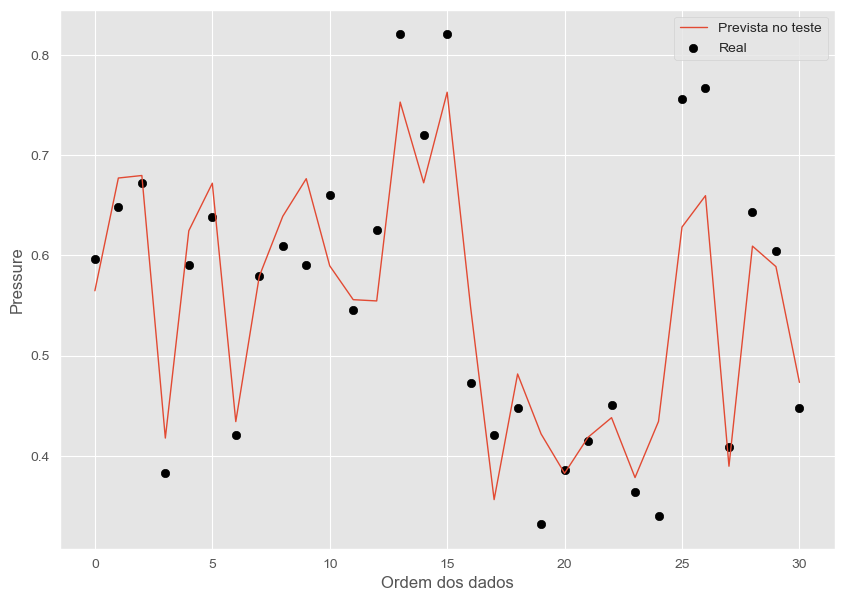

In [34]:
# avaliação conjunto de teste
n = 31
plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(range(n), y_hat_test, label="Prevista no teste", lw=1)#y_hat_test é a prediçã osobre os dados de teste
plt.scatter(range(n), y_test, color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Ordem dos dados")
plt.legend(loc="best")
f.savefig("rnn_demanda1.png")
plt.show()

Acima, a previsão é feita da forma tradicional, isto é, colocando a probabilidade de Dropout em 0%, usando assim toda a capacidade da rede. Esse é o padrão do Keras e precisaremos rescrevê-lo para implementar Monte-Carlo Dropout, no qual mantemos as probabilidades de Dropout de treino também durante as previsões. Abaixo, vamos definir uma função que retornará a última camada da rede, (as previsões) dada a camada de entrada (as variáveis). Além disso, vamos definir que está função será usada tal como durante o treinamento, passando K.learning_phase().
Abaixo realizamos 1000 forwad-passes pela rede neural e obtemos 1000 previsões para cada ponto.

# MC DROPOUT

In [35]:
import tensorflow as tf
import numpy as np
from keras import backend as K

T = 1000

tf.keras.backend.set_learning_phase(1)

predict_stochastic = K.function([model.layers[0].input], [model.layers[-1].output])

y_hat_mc = np.array([predict_stochastic([X_test]) for _ in range(T)])

y_hat_mc = y_hat_mc.reshape(-1, y_test.shape[0]).T

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [36]:
y_hat_mc.shape

(31, 1000)

In [37]:
y_hat_mc=pd.DataFrame(y_hat_mc)

In [38]:
y_hat_mc # são as 1000 previsões realizadas pela rede Dropout para cada vetor teste

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.487831,0.538199,0.557766,0.497866,0.545121,0.549822,0.651621,0.552276,0.553873,0.668896,...,0.699674,0.569476,0.448442,0.644191,0.644166,0.550898,0.632493,0.524495,0.674531,0.585464
1,0.662908,0.655960,0.643317,0.621382,0.682399,0.623095,0.641955,0.634379,0.698616,0.702486,...,0.627984,0.672696,0.704476,0.708086,0.673864,0.690323,0.638777,0.680757,0.678187,0.559984
2,0.647182,0.635917,0.689011,0.656764,0.692765,0.663348,0.709703,0.710421,0.652237,0.659509,...,0.720591,0.649172,0.596128,0.655200,0.705343,0.644354,0.680337,0.676639,0.737715,0.677765
3,0.398511,0.375810,0.552792,0.414721,0.413388,0.451411,0.388339,0.521800,0.406078,0.567245,...,0.364792,0.376662,0.359906,0.390647,0.422195,0.427659,0.559661,0.417968,0.554275,0.348720
4,0.669119,0.619626,0.585871,0.653317,0.578595,0.608238,0.531691,0.595374,0.593113,0.537151,...,0.617581,0.515732,0.620383,0.570337,0.587260,0.570328,0.665794,0.665222,0.567885,0.655932
5,0.669279,0.615012,0.698320,0.683459,0.651684,0.630568,0.668655,0.615325,0.584420,0.678766,...,0.780227,0.696479,0.562113,0.669982,0.650081,0.619853,0.587342,0.669006,0.633312,0.664035
6,0.391599,0.374446,0.397104,0.363319,0.413323,0.443666,0.426115,0.614793,0.508701,0.422121,...,0.431161,0.497240,0.394160,0.385434,0.413038,0.484907,0.425556,0.437163,0.389213,0.581461
7,0.596665,0.631108,0.608959,0.563234,0.652338,0.552743,0.561758,0.571939,0.539135,0.571027,...,0.649823,0.554658,0.626338,0.628218,0.579246,0.581439,0.565078,0.592335,0.554203,0.617396
8,0.651278,0.610964,0.675307,0.578753,0.554922,0.657190,0.695104,0.602487,0.641344,0.514993,...,0.571628,0.518825,0.605895,0.589206,0.574624,0.602724,0.643711,0.638207,0.624530,0.660934
9,0.617580,0.640156,0.664924,0.647851,0.700850,0.668145,0.651984,0.677060,0.668729,0.597086,...,0.703209,0.591321,0.588112,0.657592,0.647338,0.677492,0.686573,0.654172,0.687103,0.702529


In [39]:
yhat=pd.DataFrame(y_hat_mc)

In [40]:
#vamos calcular a média dos 1000 resultados para cada amostra de teste

In [41]:
yhat['mean']=yhat.apply(np.mean,axis=1)

In [42]:
#separamos novamente os 1000 resultados retitrando a coluna média 

In [43]:
yhatd=yhat.iloc[:,0:1000]

In [44]:
#vamos calcular o desvio padrão dos 1000 resultados dos dados de teste

In [45]:
yhatd['std']=yhatd.apply(np.std,axis=1)

In [46]:
#Abaixo os valores reais para y do conjunto de teste

In [47]:
y_test=pd.DataFrame(y_test)

In [48]:
#resetando o índice 

In [49]:
y_test=y_test.reset_index(drop=True)

In [50]:
#retirado a coluna 0

In [51]:
mean=yhat.iloc[:,1000]

In [52]:
mean=pd.DataFrame(mean)

In [53]:
desvpad=yhatd.iloc[:,1000]

In [54]:
desvpad=pd.DataFrame(desvpad)

# Determinação do erro aleatório e sistemático somente no teste  

In [55]:
#colocar tudo em uma tabela

In [56]:
df.resume=pd.concat([y_test,mean,desvpad],axis=1)

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_16172\1750862409.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.resume=pd.concat([y_test,mean,desvpad],axis=1)


In [57]:
erro2=df.resume['mean']-df.resume[5]


In [58]:
erro2

0    -0.013680
1     0.007041
2     0.000363
3     0.035316
4     0.016709
5     0.012285
6     0.005266
7     0.009337
8     0.002441
9     0.055177
10   -0.091892
11    0.018449
12   -0.060936
13   -0.104112
14   -0.072595
15   -0.083385
16    0.082033
17   -0.037850
18    0.020754
19    0.138575
20   -0.005405
21   -0.009453
22   -0.012913
23    0.023555
24    0.097576
25   -0.152888
26   -0.090981
27   -0.023981
28   -0.023914
29   -0.035118
30    0.022543
dtype: float64

In [59]:
es2=erro2.loc[:,].mean()

ea2=erro2.loc[:,].std()


In [60]:
es2

-0.008763906736905105

In [61]:
es

-0.001907867641346774

In [62]:
ea2

0.06081570505572322

In [63]:
ea

0.06894005786682286

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


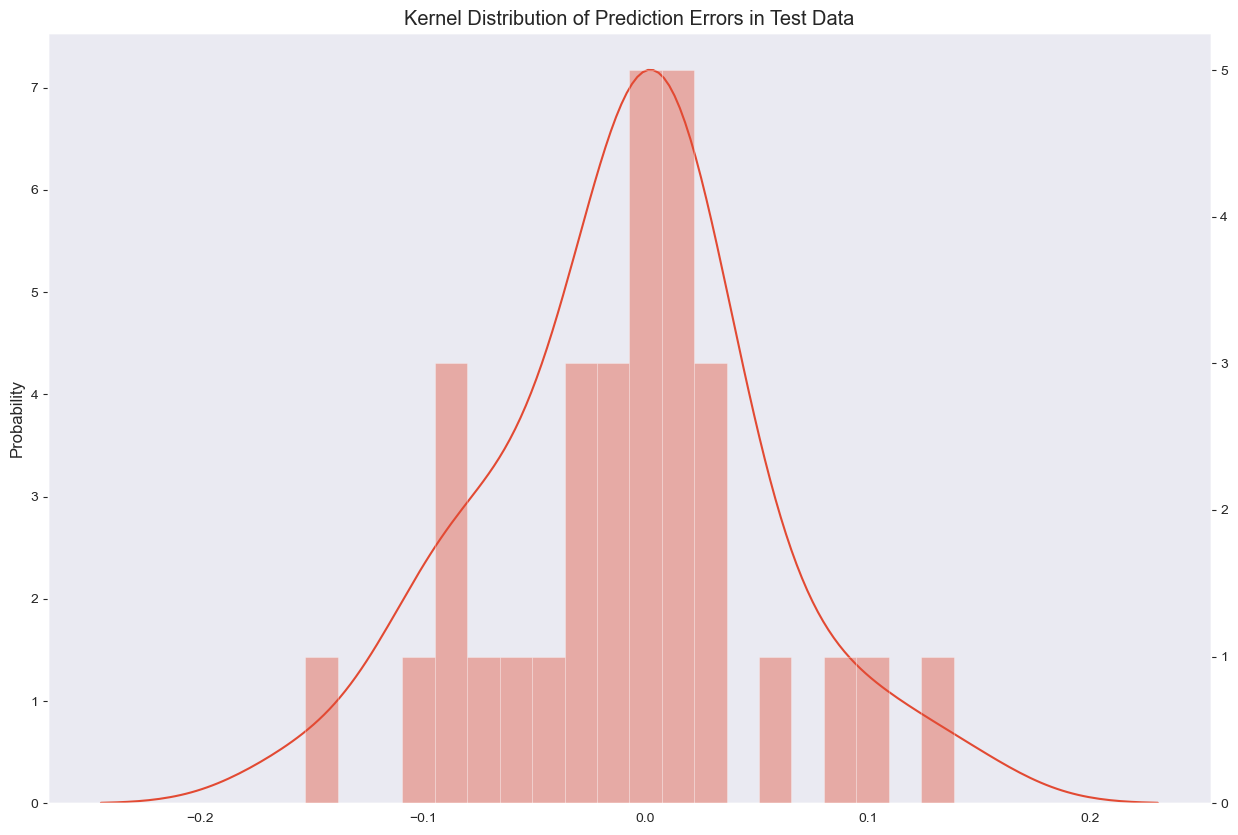

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

bins = 20

# Criando o ambiente do gráfico 
sns.set_style("dark")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Insere curva KDE (Kernel Density Estimation)
g1 = sns.distplot(erro2, ax=ax, 
                  kde=True, hist=False) 

# Insere histograma
ax_copy = ax.twinx()
g2 = sns.distplot(erro2, ax=ax_copy, kde=False, hist=True, 
             bins=bins, norm_hist=False)

# Ajusta rótulos
g1.set_ylabel("Probability")
g2.set_title("Kernel Distribution of Prediction Errors in Test Data")

plt.show()


# Determinação erro aleatório e sistemático em todos os dados (Dropout) 

In [65]:
import tensorflow as tf
import numpy as np
from keras import backend as K

T = 1000

tf.keras.backend.set_learning_phase(1)

predict_stochastic = K.function([model.layers[0].input], [model.layers[-1].output])

y_hat_mct = np.array([predict_stochastic([X]) for _ in range(T)])

y_hat_mct = y_hat_mct.reshape(-1, y.shape[0]).T

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [66]:
yhatt=pd.DataFrame(y_hat_mct)

In [67]:
yhatt

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.602380,0.639050,0.599549,0.620875,0.635896,0.668870,0.691848,0.607331,0.676403,0.601148,...,0.615781,0.632594,0.745444,0.479443,0.639313,0.578560,0.634996,0.571464,0.590232,0.606686
1,0.637174,0.552264,0.616902,0.616389,0.600097,0.699608,0.626860,0.617931,0.626495,0.652945,...,0.600582,0.636091,0.676857,0.626087,0.596237,0.608778,0.650870,0.601031,0.606117,0.589774
2,0.622344,0.608497,0.686503,0.631766,0.611306,0.627852,0.620515,0.608748,0.597716,0.613198,...,0.646132,0.617093,0.622489,0.622339,0.573468,0.612206,0.579364,0.620631,0.606868,0.765154
3,0.620787,0.607041,0.562811,0.640445,0.613390,0.628587,0.643777,0.590039,0.565742,0.637228,...,0.634893,0.628511,0.646018,0.591853,0.608640,0.613824,0.625732,0.630334,0.628236,0.555575
4,0.581116,0.599616,0.564835,0.574943,0.547920,0.563167,0.567143,0.593949,0.493645,0.554467,...,0.598027,0.624199,0.750198,0.605362,0.614522,0.627267,0.521735,0.521718,0.530056,0.631711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,0.135803,0.225375,0.305132,0.026696,0.158690,0.301728,0.270746,0.121398,0.259241,0.223703,...,0.320834,0.074197,0.289623,0.271320,0.308259,0.359671,0.198664,0.380150,0.241542,0.154906
1499,0.325698,0.264172,0.252634,0.124492,0.127080,0.198964,0.174562,0.211196,0.200163,0.231865,...,0.208455,0.384117,0.211681,0.297454,0.279592,0.337523,0.230092,0.096233,0.008736,0.173674
1500,0.153203,0.092713,0.151535,0.122177,-0.003223,0.161147,0.058022,0.284476,0.123653,0.198038,...,0.180176,0.465677,0.065104,-0.008546,-0.109480,-0.022292,0.197510,0.035210,0.237300,0.140322
1501,-0.032360,0.286675,0.006254,0.101293,0.318148,0.046828,0.171156,0.231619,0.585175,-0.079193,...,0.154876,0.478094,0.204491,0.330567,0.239183,0.049228,0.007307,0.061976,0.321146,0.290259


In [68]:
meanyhatt=yhatt.apply(np.mean,axis=1)

In [69]:
desvyhatt=yhatt.apply(np.std,axis=1)

In [70]:
erro3=meanyhatt-y

In [71]:
erro3

0       0.012265
1       0.043361
2       0.021916
3      -0.031576
4      -0.052932
          ...   
1498    0.062182
1499    0.056598
1500    0.092350
1501    0.089019
1502    0.096560
Length: 1503, dtype: float64

In [72]:
es3=erro3.loc[:,].mean()

ea3=erro3.loc[:,].std()


C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


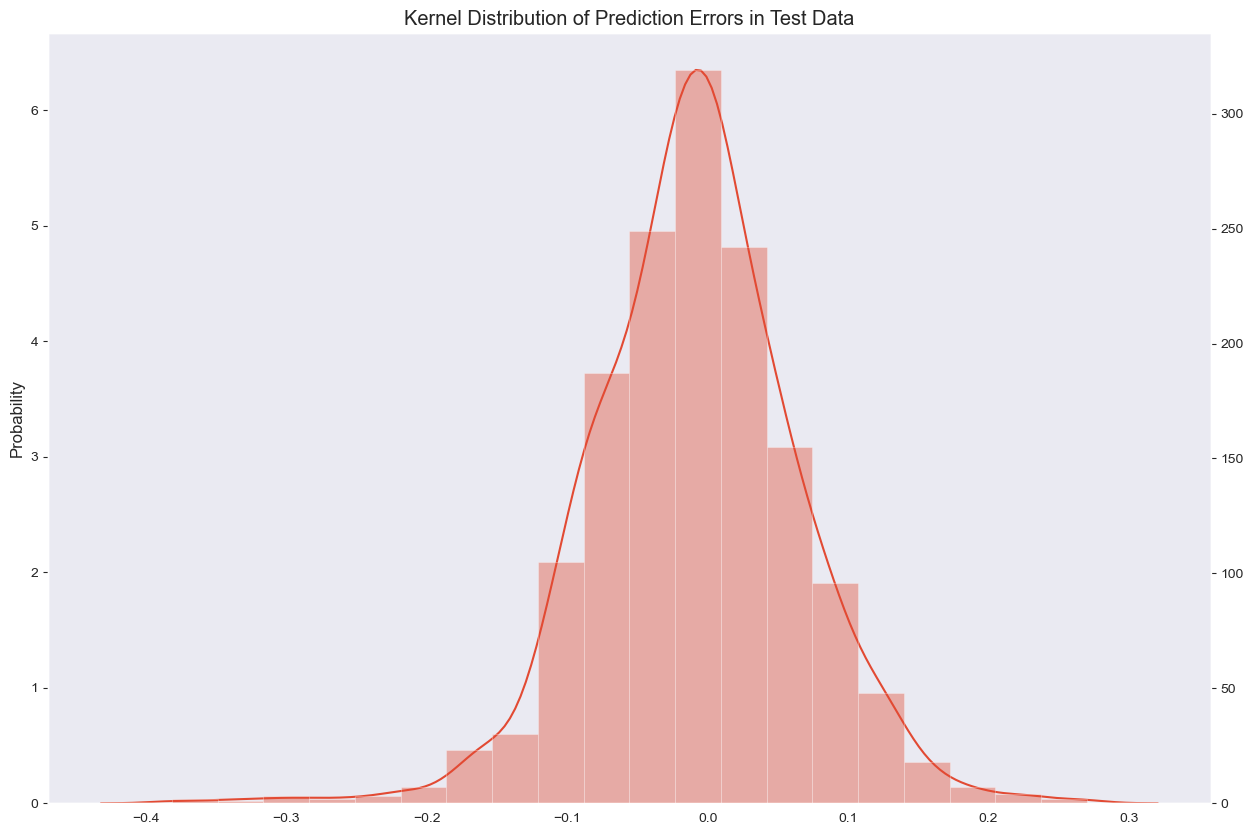

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

bins = 20

# Criando o ambiente do gráfico 
sns.set_style("dark")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Insere curva KDE (Kernel Density Estimation)
g1 = sns.distplot(erro3, ax=ax, 
                  kde=True, hist=False) 

# Insere histograma
ax_copy = ax.twinx()
g2 = sns.distplot(erro3, ax=ax_copy, kde=False, hist=True, 
             bins=bins, norm_hist=False)

# Ajusta rótulos
g1.set_ylabel("Probability")
g2.set_title("Kernel Distribution of Prediction Errors in Test Data")

plt.show()


In [74]:
#Computamos média e variância para cada ponto no set de teste.

In [75]:
es3

-0.00903980401322842

In [76]:
ea3

0.0726851180754766

In [77]:
l = 10
y_hat_test_mean = np.mean(y_hat_mc, axis=1) # média das 1000 previsões para cada ponto 
y_hat_test_variance = np.var(y_hat_mc, axis=1) 
tau = l**2 * (1 - p_dropout) / (2 * X_train.shape[0] * lbd)
y_hat_test_variance += tau**-1  # variância das 1000 previsões para cada ponto 

In [78]:
metrics.mean_absolute_error(y_test, y_hat_test_mean)

0.04408134258615819

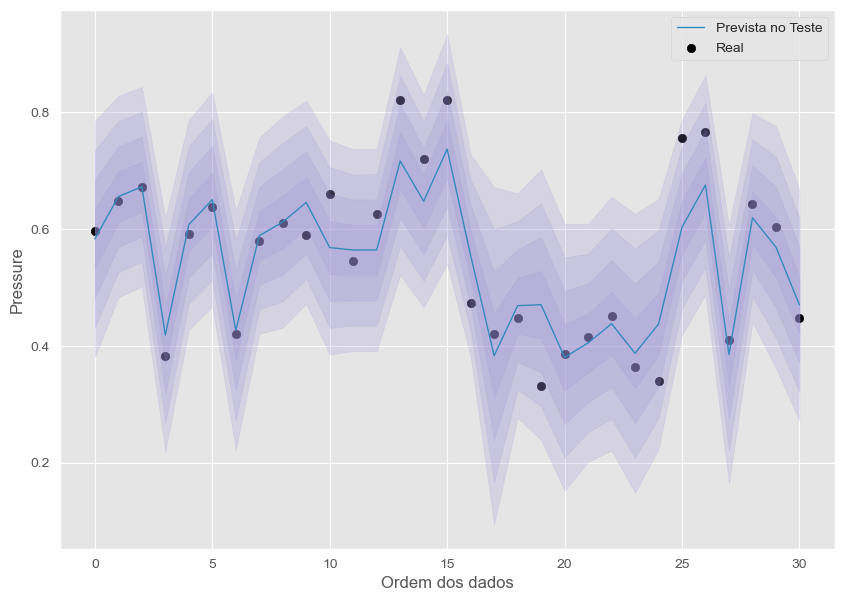

In [79]:
n = 31
t = range(n) 
mu = y_hat_test_mean
sigma = np.sqrt(y_hat_test_variance)

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Prevista no Teste", color="C1", lw=1)
plt.scatter(t, y_test, color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma* (.5*shade), mu-sigma * (.5*shade), alpha=0.2, color="C2")

plt.ylabel("Pressure")
plt.xlabel("Ordem dos dados")
plt.legend(loc="best")
f.savefig("rnn_demanda_test.png")
plt.show()

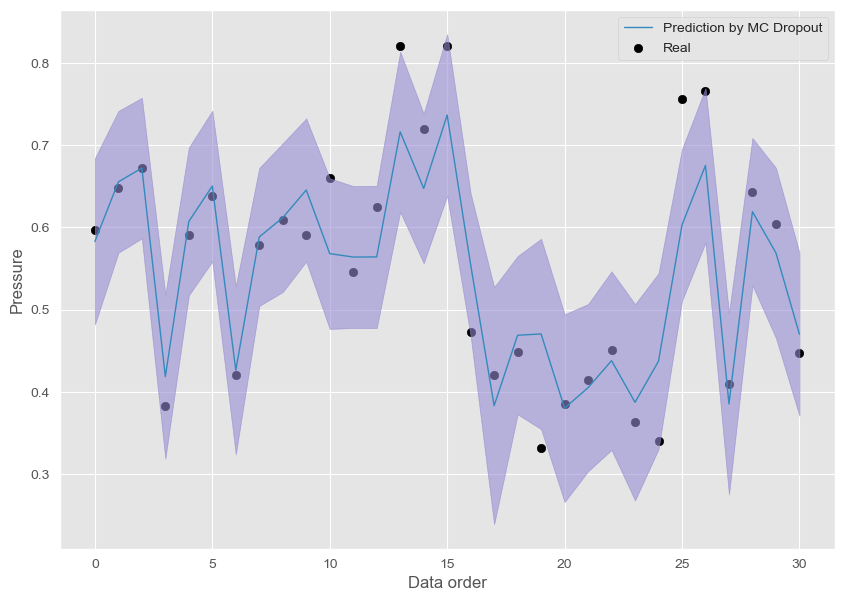

In [154]:
n = 31
t = range(n) 
mu = y_hat_test_mean
sigma = np.sqrt(y_hat_test_variance)

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Prediction by MC Dropout", color="C1", lw=1)
plt.scatter(t, y_test, color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma, mu-sigma, alpha=0.2, color="C2")

plt.ylabel("Pressure")
plt.xlabel("Data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test.svg")
plt.show()

# Determinação das incertezas da rede método JCGM 100: 2008

In [81]:
X_test=X_test.reset_index(drop=True)

In [82]:
X_test

,0,1,2,3,4
0,0.040404,0.783784,0.000000,1.000000,0.270697
1,0.116162,0.000000,0.454545,0.601010,0.022858
2,0.090909,0.000000,0.454545,1.000000,0.020653
3,0.242424,0.000000,1.000000,0.199495,0.046555
4,0.116162,0.121622,0.454545,0.199495,0.043912
5,0.070707,0.301802,0.272727,0.199495,0.092743
6,0.308081,0.121622,0.454545,0.199495,0.043912
7,0.015152,0.090090,0.727273,0.199495,0.052836
8,0.030303,0.328829,0.727273,0.199495,0.205952
9,0.040404,0.238739,0.727273,0.199495,0.098992


In [83]:

 previsão=model.predict(X_test[:31])


1/1 [==============================] - 0s 18ms/step


In [84]:
colnames=["Predict"]

In [85]:
previsão1=pd.DataFrame(previsão, columns=colnames)

In [86]:
df.resume3=pd.concat([X_test,y_test,previsão1],axis=1)

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_16172\3988421289.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.resume3=pd.concat([X_test,y_test,previsão1],axis=1)


In [87]:
#criar a coluna de predict delta x1 

In [88]:
#método numerico para derivadas parcias: método das diferenças onde h=0.000001

In [89]:
h1=0.000001
h2=0.000001
h3=0.000001
h4=0.000001
h5=0.000001

In [90]:
deltax1=X_test[:31]+np.array([h1,0,0,0,0])

In [91]:
previsãodeltax1=model.predict(deltax1[:31])


1/1 [==============================] - 0s 16ms/step


In [92]:
colnames=["Predict Deltax1"]
previsãodeltax1=pd.DataFrame(previsãodeltax1, columns=colnames)

In [93]:
#criar a coluna de predict delta x2

In [94]:
#incerteza de x2 (medidor de ângulo)

In [95]:
deltax2=X_test[:31]+np.array([0,h2,0,0,0])

In [96]:
previsãodeltax2=model.predict(deltax2[:31])

1/1 [==============================] - 0s 18ms/step


In [97]:
colnames=["Predict Deltax2"]
previsãodeltax2=pd.DataFrame(previsãodeltax2, columns=colnames)

In [98]:
#criar a coluna de predict delta x3

In [99]:
#incerteza de x3 (medidor de comprimento)

In [100]:
deltax3=X_test[:31]+np.array([0,0,h3,0,0])

In [101]:
previsãodeltax3=model.predict(deltax3[:31])

1/1 [==============================] - 0s 16ms/step


In [102]:
colnames=["Predict Deltax3"]
previsãodeltax3=pd.DataFrame(previsãodeltax3, columns=colnames)

In [103]:
#criar a coluna de predict delta x4

In [104]:
#incerteza de x4 (medidor de velocidade).

In [105]:
deltax4=X_test[:31]+np.array([0,0,0,h4,0])

In [106]:
previsãodeltax4=model.predict(deltax4[:31])

1/1 [==============================] - 0s 15ms/step


In [107]:
colnames=["Predict Deltax4"]
previsãodeltax4=pd.DataFrame(previsãodeltax4, columns=colnames)

In [108]:
#criar a coluna de predict delta x5

In [109]:
#incerteza de x5 (medidor de sucção)

In [110]:
deltax5=X_test[:31]+np.array([0,0,0,0,h5])

In [111]:
previsãodeltax5=model.predict(deltax5[:31])

1/1 [==============================] - 0s 16ms/step


In [112]:
colnames=["Predict Deltax5"]
previsãodeltax5=pd.DataFrame(previsãodeltax5, columns=colnames)

In [113]:
df.total=pd.concat([y_test,previsão1,previsãodeltax1,previsãodeltax2,previsãodeltax3,previsãodeltax4,previsãodeltax5],axis=1)

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_16172\2651709830.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.total=pd.concat([y_test,previsão1,previsãodeltax1,previsãodeltax2,previsãodeltax3,previsãodeltax4,previsãodeltax5],axis=1)


In [114]:
df.total['c1']=(df.total['Predict Deltax1']-df.total['Predict'])/h1


In [115]:
df.total['c2']=(df.total['Predict Deltax2']-df.total['Predict'])/h2


In [116]:
df.total['c3']=(df.total['Predict Deltax3']-df.total['Predict'])/h3

In [117]:
df.total['c4']=(df.total['Predict Deltax4']-df.total['Predict'])/h4

In [118]:
df.total['c5']=(df.total['Predict Deltax5']-df.total['Predict'])/h5

In [119]:
X_test.iloc[0]

0    0.040404
1    0.783784
2    0.000000
3    1.000000
4    0.270697
Name: 0, dtype: float64

In [120]:
df.total

,5,Predict,Predict Deltax1,Predict Deltax2,Predict Deltax3,Predict Deltax4,Predict Deltax5,c1,c2,c3,c4,c5
0,0.596591,0.564617,0.564620,0.564617,0.564618,0.564617,0.564617,3.576279,-0.298023,0.953674,0.000000,-0.119209
1,0.648363,0.677066,0.677066,0.677066,0.677066,0.677066,0.677066,-0.655651,0.000000,-0.298023,0.059605,-0.238419
2,0.671870,0.679566,0.679566,0.679566,0.679565,0.679566,0.679566,0.119209,0.119209,-0.178814,0.000000,0.536442
3,0.383147,0.417706,0.417705,0.417705,0.417705,0.417706,0.417705,-0.596046,-0.238419,-0.059605,0.059605,-0.625849
4,0.590555,0.624509,0.624507,0.624509,0.624508,0.624509,0.624508,-1.430511,-0.119209,-0.417233,0.059605,-0.834465
5,0.638046,0.671889,0.671885,0.671889,0.671889,0.671889,0.671888,-4.112720,0.178814,-0.238419,0.119209,-1.430511
6,0.420906,0.434124,0.434123,0.434123,0.434123,0.434124,0.434122,-0.983477,-0.476837,-0.298023,0.089407,-1.132488
7,0.579068,0.578998,0.579002,0.578998,0.578998,0.578998,0.578999,4.410744,0.119209,0.059605,0.059605,0.834465
8,0.609434,0.638862,0.638857,0.638862,0.638862,0.638862,0.638862,-4.827976,-0.476837,-0.357628,0.178814,-0.417233
9,0.590342,0.676398,0.676394,0.676398,0.676398,0.676398,0.676397,-3.993511,0.059605,-0.417233,0.119209,-0.655651


In [121]:
#cálculo da incerteza combinada : incerteza expandida de x1 a x5  desvio padrão do erro sistemático
#x1: medidor de frequencia sonora.5% do valor médio da escala
#x2: medidor de angulo :5% do valor médio da escala
#x3: medidor de comprimento 5% do valor médio da escala
#x4: medidor de velocidade do vento Pesquisando a incerteza em tuneis de vento chega a 15% do resultado . Como a velocidade média é em torno de 40 m/s estimou-se em +-6m/s²
#x5: medidor de sucção 5% do valor médio da escala
#y: pressão somora: 5% do valor médio da escala
 

In [122]:
upx1=0.0003468*0.5/2
upx2=0.00488*0.5/2
upx3=0.001470*0.5/2
upx4=0.01966*0.5/2
upx5=0.1*0.5/2
upy=0.008*0.5/2

In [123]:
df_n.rename(columns={
    0: 'Frequency',1:'Angle',2:'Length',3:'Velocity',4:'Suction Side',5:'Pressure'
   
},inplace=True)

In [124]:
correlation= df_n.corr()


In [125]:
r_12=correlation['Frequency']['Angle']

In [126]:
r_13=correlation['Frequency']['Length']

In [127]:
r_14=correlation['Frequency']['Velocity']

In [128]:
r_15=correlation['Frequency']['Suction Side']

In [129]:
r_23=correlation['Angle']['Length']

In [130]:
r_24=correlation['Angle']['Velocity']

In [131]:
r_25=correlation['Angle']['Suction Side']

In [132]:
r_34=correlation['Length']['Suction Side']

In [133]:
r_35=correlation['Length']['Velocity']

In [134]:
r_45=correlation['Velocity']['Suction Side']

<AxesSubplot:>

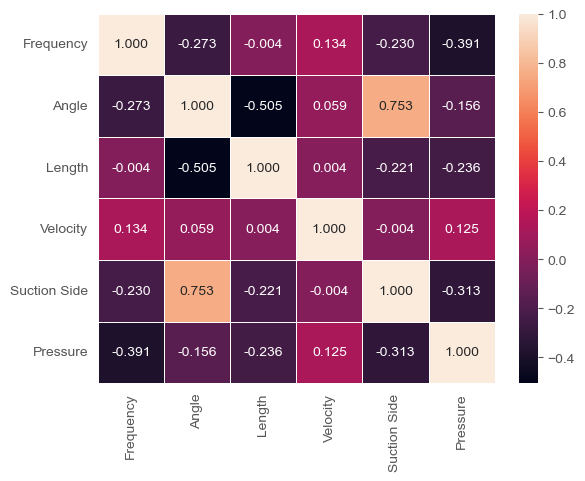

In [135]:
plot = sns.heatmap(correlation, annot = True, fmt=".3f", linewidths=.6)

plot

In [136]:
cov= df_n.cov()

In [137]:
cov

,Frequency,Angle,Length,Velocity,Suction Side,Pressure
Frequency,0.025351,-0.011578,-0.000195,0.008369,-0.008305,-0.011412
Angle,-0.011578,0.071066,-0.045059,0.006160,0.045528,-0.007634
Length,-0.000195,-0.045059,0.112085,0.000499,-0.016760,-0.014504
Velocity,0.008369,0.006160,0.000499,0.154647,-0.000354,0.009025
Suction Side,-0.008305,0.045528,-0.016760,-0.000354,0.051387,-0.013002
Pressure,-0.011412,-0.007634,-0.014504,0.009025,-0.013002,0.033651


# Determinação da incerteza aleátória, epistêmica e Preditiva 

In [138]:
ucca=((df.total['c1']*upx1)**2+
                   (df.total['c2']*upx2)**2+
                   (df.total['c3']*upx3)**2+
                   (df.total['c4']*upx4)**2+
                   (df.total['c5']*upx5)**2+
      2*df.total['c1']*df.total['c2']*upx1*upx2*r_12+
      2*df.total['c1']*df.total['c3']*upx1*upx3*r_13+
      2*df.total['c1']*df.total['c4']*upx1*upx4*r_14+
      2*df.total['c1']*df.total['c5']*upx1*upx5*r_15+
      2*df.total['c2']*df.total['c3']*upx2*upx3*r_23+
      2*df.total['c2']*df.total['c4']*upx2*upx4*r_24+
      2*df.total['c2']*df.total['c5']*upx2*upx5*r_25+
      2*df.total['c3']*df.total['c4']*upx3*upx4*r_34+
      2*df.total['c3']*df.total['c5']*upx3*upx5*r_35+
      2*df.total['c4']*df.total['c5']*upx4*upx5*r_45
                  +upy**2)**0.5

In [139]:
ucce=((ea)**2)**0.5

In [140]:
ucc=(ucca**2+ucce**2)**0.5

In [141]:
U= 2*ucc+abs(es)

In [142]:
df.total['ucca']=ucca
df.total['ucce']=ucce
df.total['ucc']=ucc
df.total['U']=U

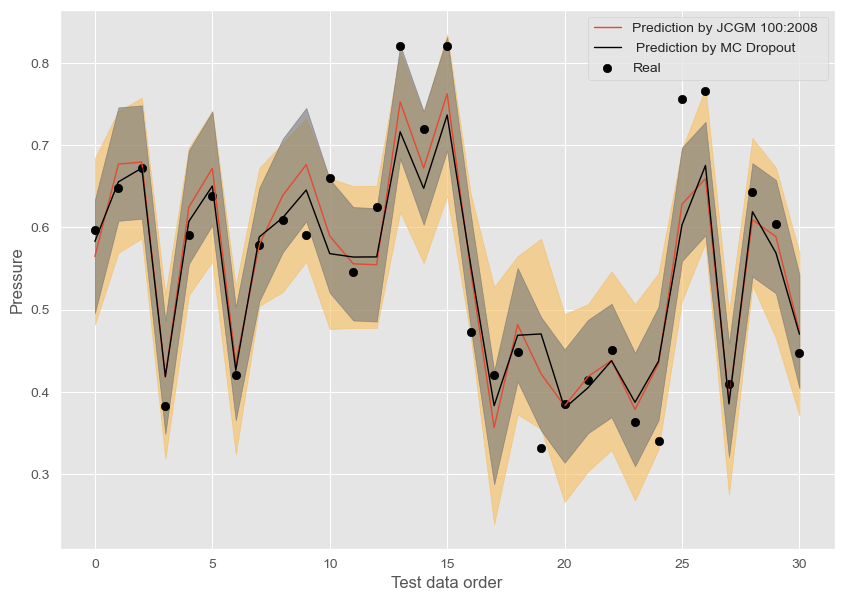

In [155]:
n = 31
t = range(n) 

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, df.total['Predict'], label="Prediction by JCGM 100:2008 ", color="C7", lw=1)
plt.plot(t, mu, label=" Prediction by MC Dropout", color="Black", lw=1)
for shade in range(1, 5):
    plt.fill_between(t, mu+sigma, mu-sigma , alpha=0.2, color="C11")
for shade in range(1, 5):
    plt.fill_between(t, df.total['Predict']-df.total['ucce'], df.total['Predict']+df.total['ucce'], alpha=0.2, color="C3")

plt.scatter(t, df.total[5], color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Test data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test3.svg")
plt.show()

In [144]:
MCCC=pd.concat([df.total[5],df.total['Predict'],df.total['ucca'],df.total['ucce'],df.total['ucc'],df.total['U']],axis=1)

In [145]:
# Definir os nomes das colunas
nomes_colunas = ['Real','GUM Predict','GUM Aleatoric Uncertainty','GUM Epistemic Uncertainty','GUM Preditive Uncertainty','GUM_U_exp']

# Atribuir os nomes das colunas ao DataFrame
MCCC.columns = nomes_colunas



In [146]:
MCCC

,Real,GUM Predict,GUM Aleatoric Uncertainty,GUM Epistemic Uncertainty,GUM Preditive Uncertainty,GUM_U_exp
0,0.596591,0.564617,0.003933,0.06894,0.069052,0.140012
1,0.648363,0.677066,0.006285,0.06894,0.069226,0.140360
2,0.671870,0.679566,0.013666,0.06894,0.070282,0.142471
3,0.383147,0.417706,0.015984,0.06894,0.070769,0.143445
4,0.590555,0.624509,0.021042,0.06894,0.072080,0.146068
5,0.638046,0.671889,0.035582,0.06894,0.077581,0.157070
6,0.420906,0.434124,0.028807,0.06894,0.074717,0.151341
7,0.579068,0.578998,0.020984,0.06894,0.072063,0.146033
8,0.609434,0.638862,0.011000,0.06894,0.069812,0.141532
9,0.590342,0.676398,0.016397,0.06894,0.070863,0.143634


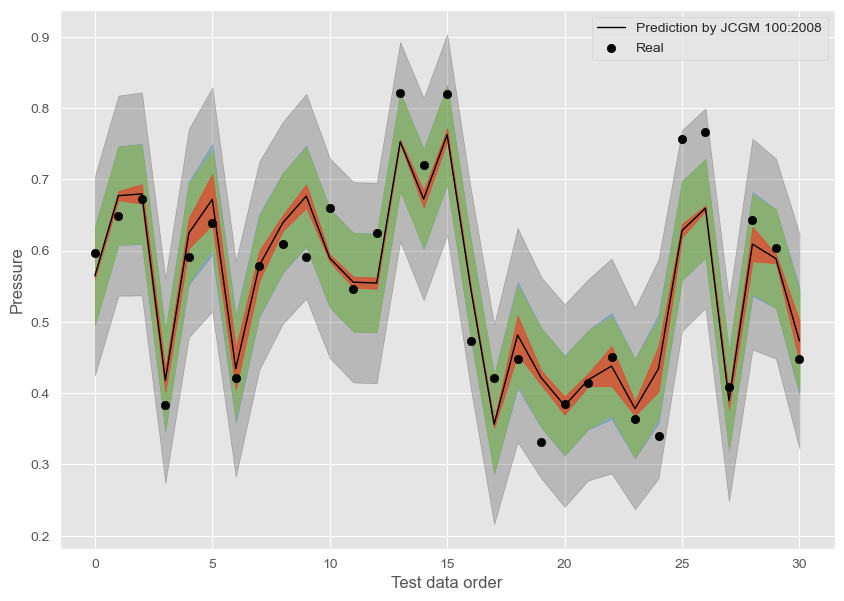

In [152]:
n = 31
t = range(n) 

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, MCCC['GUM Predict'], label='Prediction by JCGM 100:2008', color="Black", lw=1)

for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM_U_exp'],  MCCC['GUM Predict']+MCCC['GUM_U_exp'], alpha=0.05, color="black")
for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Preditive Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Preditive Uncertainty'], alpha=0.1, color="C8")
for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Epistemic Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Epistemic Uncertainty'], alpha=0.2, color="C5")
for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Aleatoric Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Aleatoric Uncertainty'], alpha=0.3, color="C7")

plt.scatter(t, MCCC['Real'], color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Test data order")
plt.legend(loc="best")

f.savefig("rnn_demanda_test3.svg",format='svg')

# Determinação da Incerteza para um dado "vi" qualquer 

In [148]:
#matriz das incertezas 
I = [
    [upx1**2, upx1*upx2,upx1*upx3,upx1*upx4,upx1*upx5],[0, upx2**2,upx2*upx3,upx2*upx4,upx2*upx5],
    [0, 0,upx3**2,upx3*upx4,upx3*upx5], [0, 0,0,upx4**2,upx4*upx5],
   [0, 0,0,0,upx5**2]]
Id=pd.DataFrame(I)
print(Id)

              0             1             2             3         4
0  7.516890e-09  1.057740e-07  3.186225e-08  4.261305e-07  0.000002
1  0.000000e+00  1.488400e-06  4.483500e-07  5.996300e-06  0.000030
2  0.000000e+00  0.000000e+00  1.350562e-07  1.806262e-06  0.000009
3  0.000000e+00  0.000000e+00  0.000000e+00  2.415723e-05  0.000123
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000625


In [149]:
#matriz dos coeficientes de correlação 
correlation= df_n.corr()
matriz =correlation.values
print(matriz)

[[ 1.         -0.27276454 -0.00366064  0.13366383 -0.23010735 -0.39071141]
 [-0.27276454  1.         -0.50486815  0.05875957  0.75339378 -0.15610753]
 [-0.00366064 -0.50486815  1.          0.00378663 -0.22084243 -0.23616151]
 [ 0.13366383  0.05875957  0.00378663  1.         -0.00397401  0.1251028 ]
 [-0.23010735  0.75339378 -0.22084243 -0.00397401  1.         -0.31266951]
 [-0.39071141 -0.15610753 -0.23616151  0.1251028  -0.31266951  1.        ]]


In [150]:
# Matriz das covariâncias 
A = I
B = matriz

# Criando uma nova matriz C multiplicando os elementos correspondentes de A e B
C = []

for i in range(len(A)):
    new_row = []
    for j in range(len(A[0])):
        new_row.append(A[i][j] * B[i][j])
    C.append(new_row)

# Imprimindo a matriz resultante C
for row in C:
    print(row)
    
    
    

[7.516890000000002e-09, -2.8851396047005582e-08, -1.166361909109106e-10, 5.6958235018325675e-08, -4.987576878241828e-07]
[-0.0, 1.4883999999999998e-06, -2.2635763494678856e-07, 3.523399803148725e-07, 2.297851043196485e-05]
[-0.0, -0.0, 1.3505625e-07, 6.839645543964059e-09, -2.0289898340245836e-06]
[0.0, 0.0, 0.0, 2.4157225e-05, -4.883068699328283e-07]
[-0.0, 0.0, -0.0, -0.0, 0.0006250000000000001]


In [151]:
#matriz das derivadas parciais 
#definindo um vi 
x1=0.040404
x2= 0.783784
x3=0.000000
x4=1.000000
x5=0.270697
data = { 'x1': [x1],'x2': [x2],'x3': [x3],'x4': [x4],'x5': [x5]
}
# Criando um DataFrame a partir do dicionário
vi=pd.DataFrame(data)
# dado um vi pertencente ao domínio X
h=0.000001
yi=model.predict(vi)
c1=(model.predict(vi+np.array([h,0,0,0,0]))-model.predict(vi))/h
c2=(model.predict(vi+np.array([0,h,0,0,0]))-model.predict(vi))/h
c3=(model.predict(vi+np.array([0,0,h,0,0]))-model.predict(vi))/h
c4=(model.predict(vi+np.array([0,0,0,h,0]))-model.predict(vi))/h
c5=(model.predict(vi+np.array([0,0,0,0,h]))-model.predict(vi))/h

#matriz dos coef.de sensibilidade 
CS = [
    [c1**2, 2*c1*c2,2*c1*c3,2*c1*c4,2*c1*c5],[0, c2**2,2*c2*c3,2*c2*c4,2*c2*c5],
    [0, 0,c3**2,2*c3*c4,2*c3*c5], [0, 0,0,c4**2,2*c4*c5],
   [0, 0,0,0,c5**2]]

# Matriz das contribuições para incerteza 
A = C
B = CS

# Criando uma nova matriz C multiplicando os elementos correspondentes de A e B
MC = []

for i in range(len(A)):
    new_row = []
    for j in range(len(A[0])):
        new_row.append(A[i][j] * B[i][j])
    MC.append(new_row)
    
# Inicializando a variável de soma
soma_total = 0

# Percorrendo a matriz e somando os elementos
for linha in MC:
    for elemento in linha:
        soma_total += elemento

ucca_vi=(soma_total)**0.5
ucce_vi=((ea)**2)**0.5
ucc_vi=(ucca_vi**2+ucce_vi**2)**0.5
Up_vi= 2*ucc_vi+abs(es)
Up_vi

1/1 [==============================] - 0s 16ms/step


array([[0.13984844]], dtype=float32)